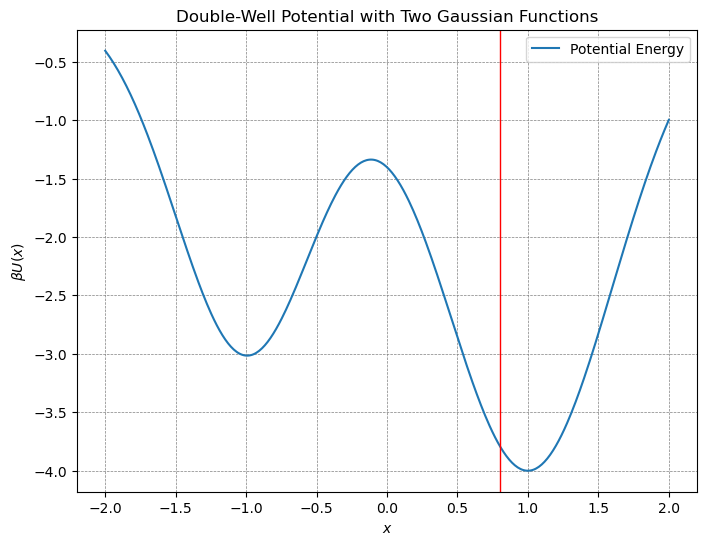

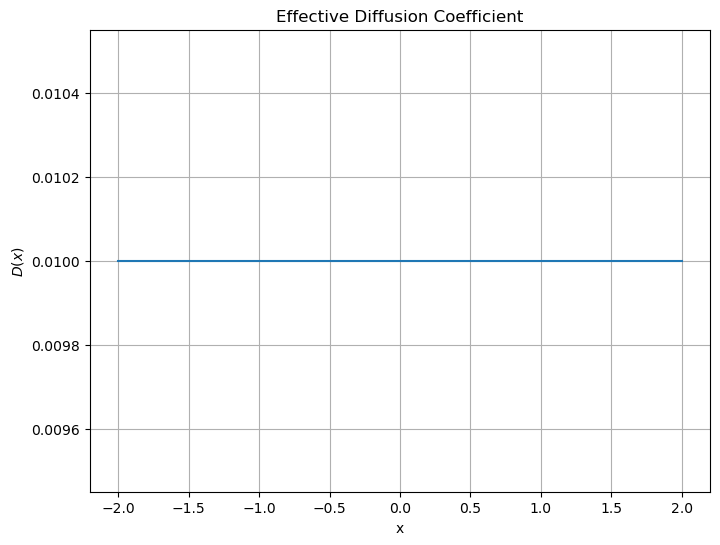

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the double-well potential using two Gaussian functions
def double_gaussian_potential(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0.8, color='red',linewidth=1)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, D(x))
plt.xlabel('x')
plt.ylabel("$D(x)$")
plt.title('Effective Diffusion Coefficient')
plt.grid(True)
plt.show()


In [2]:
a = -2.0   # location of reflecting boundary
b = 0.8   # location of absorbing boundary
h = 0.01
N = int((b-a)/h+1)
x_arr = np.linspace(a, b, N)

#### Steady State Distribution - Numerical solve ODE with injecting boundary condition

In [3]:
def kappa(x):
    return D(x)*np.exp(-beta_U(x))

x_minus_half = x_arr - h/2.0
x_plus_half = x_arr + h/2.0
u_arr = np.zeros(x_arr.size)

A = np.zeros((N-1, N-1))
np.fill_diagonal(A, -(kappa(x_minus_half)+kappa(x_plus_half)))
np.fill_diagonal(A[1:, ], kappa(x_minus_half[1:-1])) # subdiagonal
np.fill_diagonal(A[:, 1:], kappa(x_plus_half[:-2]))  # superdiagonal
A[0, 1] += kappa(x_minus_half[0])

f_vect = np.zeros(N-1)
f_vect[0] = 1

u_arr[0:-1] = spsolve(A, f_vect)
Pst_arr = u_arr*np.exp(-beta_U(x_arr))
Pst_arr /= (np.sum(Pst_arr)*h)

#### Steady-State Flux and Probability Distribution Function - Numerically Nest integrate the expression (referred to be exact) 

In [4]:
# Define the inner function to integrate as a function of y
def inner_integrand(y):
    return 1.0/D(y)*np.exp(beta_U(y))

# Define the inner integral as a function of x
def inner_integral(x):
    y_lower = x
    y_upper = b
    result, error = quad(inner_integrand, y_lower, y_upper)
    return result

# Define the outer integral
x_lower = a
x_upper = b

# Define the outer function to integrate (also as a function of x)
def outer_integrand(x):
    return np.exp(-beta_U(x))*inner_integral(x)

# Perform the outer integration
invert_st_flux, error = quad(outer_integrand, x_lower, x_upper)
st_flux = 1.0/invert_st_flux

In [5]:
def st_P_func(x):
    def integrand(y):
        return 1.0/D(y)*np.exp(beta_U(y))
    # Perform the integration
    y_lower = x
    y_upper = b
    result, error = quad(integrand, y_lower, y_upper)
    result *= st_flux*np.exp(-beta_U(x))
    return result

st_P_arr = np.zeros(x_arr.size)
for i in np.arange(x_arr.size):
    st_P_arr[i] = st_P_func(x_arr[i])

#### Steady State Distribution Plots

[0.16254088 0.16291158 0.16336963 0.16391799 0.16455972] [0.16267392 0.16304497 0.16350344 0.16405229 0.16469458]


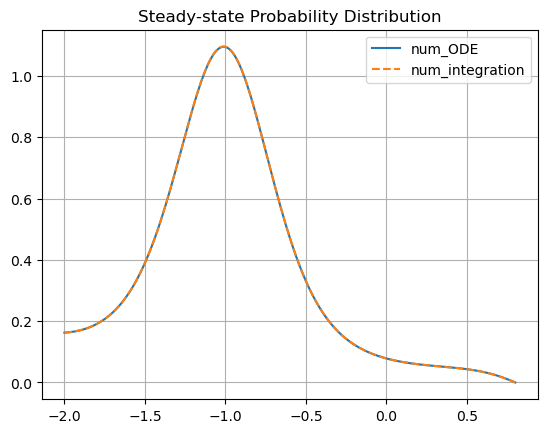

In [6]:
plt.plot(x_arr, Pst_arr, label='num_ODE')
plt.plot(x_arr, st_P_arr, '--', label='num_integration')
plt.title('Steady-state Probability Distribution')
plt.grid()
plt.legend()

print(Pst_arr[:5], st_P_arr[:5])

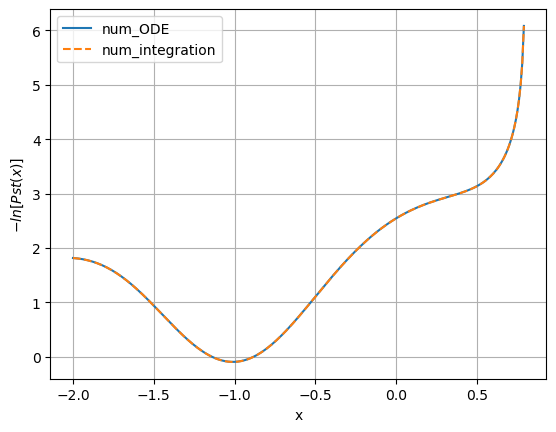

In [7]:
plt.plot(x_arr, -np.log(Pst_arr), label='num_ODE')
plt.plot(x_arr, -np.log(st_P_arr), '--', label='num_integration')
plt.xlabel('x')
plt.ylabel("$-ln[Pst(x)]$")
plt.grid()
plt.legend()

#### Numerically Nest integrate for MFPT - referred to be exact

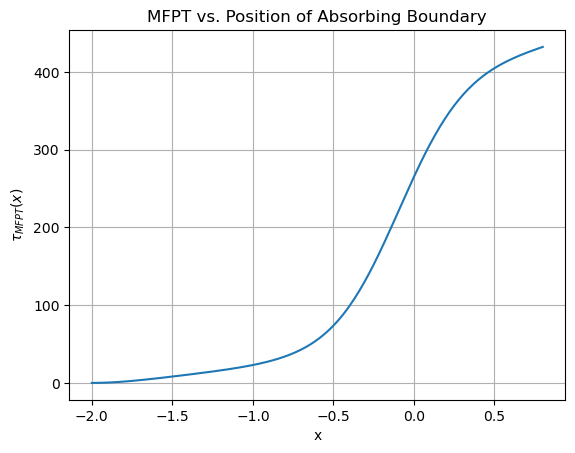

In [8]:
x0 = a   # Regura's method, overlap the starting point and reflecting boundary

# Define the inner function to integrate as a function of z
def inner_integrand(z):
    return np.exp(-beta_U(z))

# Define the inner integral as a function of y
def inner_integral(y):
    z_lower = a
    z_upper = y
    result, error = quad(inner_integrand, z_lower, z_upper)
    return result

# Define the outer integral
y_lower = x0
y_upper = b

# Define the outer function to integrate (also as a function of y)
def outer_integrand(y):
    return np.exp(beta_U(y))*inner_integral(y)/D(y)

# Perform the outer integration (from x0 to b)
result, error = quad(outer_integrand, y_lower, y_upper)

mfpt_arr = np.zeros(x_arr.size)
for i in np.arange(x_arr.size):
    mfpt_arr[i], _ = quad(outer_integrand, y_lower, x_arr[i])

plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.plot(x_arr, mfpt_arr)
plt.title('MFPT vs. Position of Absorbing Boundary')
plt.grid()

#### Reconstruct Free Energy from Numerical Solution of Pst_arr and Numerical Integration of MFPT

1.0346551525309143e-07


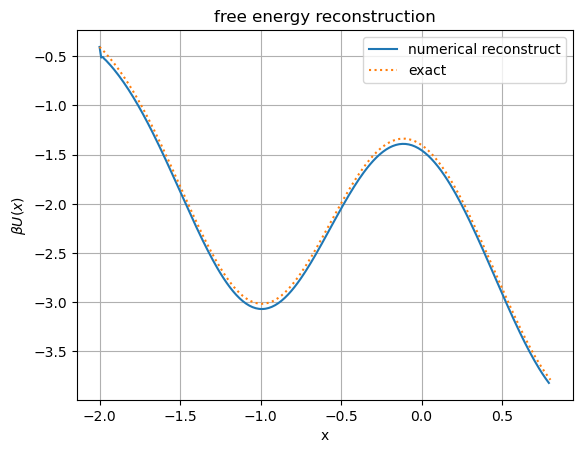

In [9]:
interp_Pst_func = interp1d(x_arr, Pst_arr, kind='cubic', fill_value="extrapolate")
# Except for the absorbing boundary Pst(b) = 0, and also avoid D(x)=0
integral_Pst_arr = np.zeros(N-1)
Bx_arr = np.zeros(N-1)
for i in range(N-1):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[i], x_arr[-1])
    Bx_arr[i] = -1.0/Pst_arr[i]*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[i])/(mfpt_arr[-1]))
interp_invertBx_func = interp1d(x_arr[:-1], 1.0/Bx_arr, kind='cubic', fill_value="extrapolate")

integral_invertBx_arr = np.zeros(N-1)
beta_Urec1_arr = np.zeros(N-1)
for i in range(x_arr.size-1):
    # Here x0 is b_arr[0]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[0], x_arr[i])
    beta_Urec1_arr[i] = beta_U(x_arr[0])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]
print(_)

plt.plot(x_arr[:-1], beta_Urec1_arr, label="numerical reconstruct")
plt.plot(x_arr, beta_U(x_arr), ":", label="exact")

# Plot formatting
plt.xlabel('x')
plt.ylabel(r'$ \beta U(x) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### Pst and MFPT calculated by Transfer Matrix with Recycling Boundary Condition

In [10]:
from transfer_matrix_reptile import TransferMatrix_ReInAb

ria_trans = TransferMatrix_ReInAb(h, x_arr, beta_U, 0)

[1.        +0.j         0.99963059-0.00017818j 0.99963059+0.00017818j
 0.99891501-0.00038286j 0.99891501+0.00038286j 0.99768309-0.00056821j]


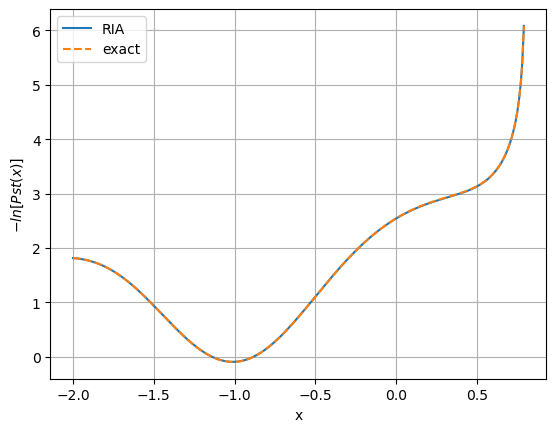

In [11]:
# plt.plot(x_arr[:-1], ria_trans.steady_state, label="RIA")
# plt.plot(x_arr, st_P_arr, '--', label="exact")
plt.plot(x_arr[:-1], -np.log(ria_trans.steady_state), label="RIA")
plt.plot(x_arr, -np.log(st_P_arr), '--', label="exact")
print(ria_trans.eig6_w)

plt.xlabel('x')
plt.ylabel("$-ln[Pst(x)]$")
plt.legend()
plt.grid()

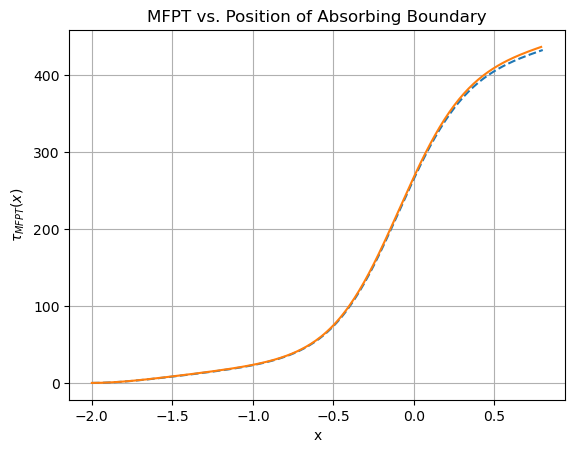

In [12]:
ria_P = ria_trans.trans_mat.T
vec_pi = ria_trans.eig6_v[:,0].real/np.sum(ria_trans.eig6_v[:,0].real)
epsilon = np.ones(N-1)
mat_I = np.eye(N-1)
mat_E = np.ones((N-1, N-1))
mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
vec_Zdg = np.diag(mat_Z)
mat_Zdg = np.diag(vec_Zdg)
mat_Mdg = np.diag(1/vec_pi)
mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
mat_Mbar = mat_M - mat_Mdg

delt_t = h**2/(2*D0)
plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.plot(x_arr, mfpt_arr, '--')
plt.plot(x_arr[:-1], delt_t*mat_Mbar[0])

plt.title('MFPT vs. Position of Absorbing Boundary')
plt.grid()

### Extract Steady State Distribution and MFPT from Simulation

In [13]:
from mfpt_Pst_RW_simulate import simulate_ReAb, simulate_ReAb_accelerate

num_particles = 600
init_position_arr = a*np.ones(num_particles, dtype=float)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+h, h)
n_arr = np.round(n_arr, decimals=5)

In [14]:
# count_n, ti_n = simulate_ReAb_accelerate(init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx, ht=ht)
count_n, ti_n = simulate_ReAb(init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx, ht=ht)

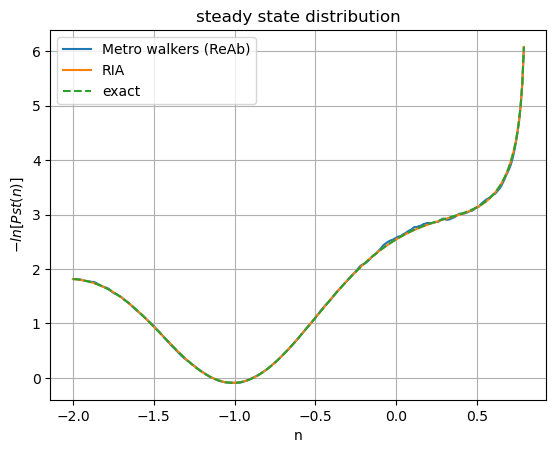

In [15]:
Pst_n = count_n/(h*np.sum(count_n))
plt.plot(n_arr[:-1], -np.log(Pst_n[:-1]), label="Metro walkers (ReAb)")
# plt.plot(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA")
plt.plot(x_arr[:-1], -np.log(ria_trans.steady_state), label="RIA")
plt.plot(x_arr[:-1], -np.log(st_P_arr[:-1]), '--', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel("$-ln[Pst(n)]$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

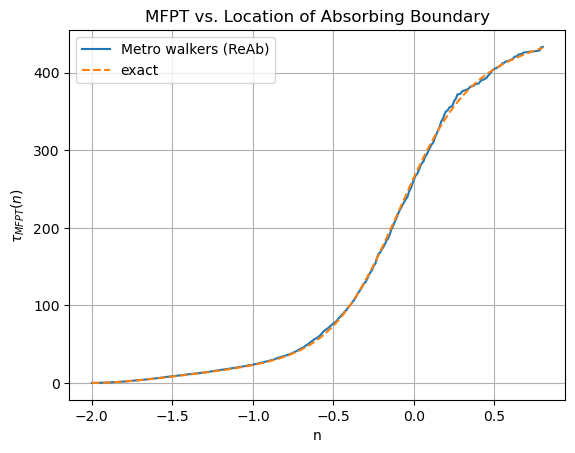

In [16]:
mfpt_simu_arr = np.mean(ti_n, axis=0)

plt.plot(n_arr, mfpt_simu_arr, label="Metro walkers (ReAb)")
plt.plot(x_arr, mfpt_arr, '--', label="exact")
# Plot formatting
plt.xlabel('n')
plt.ylabel(r'$ \tau_{MFPT} (n)$')
plt.title('MFPT vs. Location of Absorbing Boundary')
plt.legend()
plt.grid()

### Reconstruct Free Energy Using data [mfpt (mfpt_simu_arr), Pst (Pst_n)] extracted from Simulation

#### (1) Exact Steady State Distribution with simulated MFPT

0.0005854517561246147


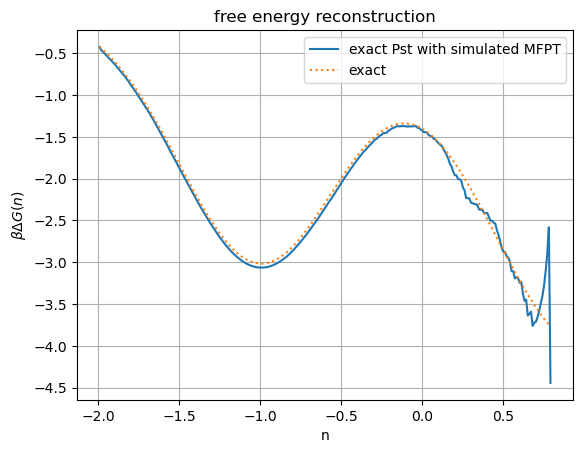

In [17]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(st_P_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/st_P_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="exact Pst with simulated MFPT")
plt.plot(x_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (2) Simulated Steady State Distribution with exact MFPT

0.00015107363757098464


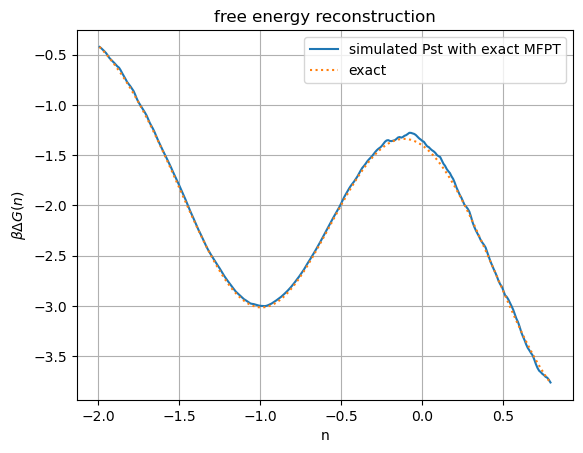

In [18]:
interp_simu_Pst_func = interp1d(n_arr, Pst_n, kind='cubic', fill_value="extrapolate")
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
simu_Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, n_arr[1+i], n_arr[-1])
    simu_Bx_arr[i] = -1.0/Pst_n[1+i]*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

interp_simu_invertBx_func = interp1d(x_arr[1:-1], 1.0/simu_Bx_arr, kind='cubic') # fill_value="extrapolate")
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, n_arr[1], n_arr[1+i])
    beta_Grec2_arr[i] = beta_U(n_arr[1])+np.log(simu_Bx_arr[i]/simu_Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(n_arr[1:-1], beta_Grec2_arr, label="simulated Pst with exact MFPT")
plt.plot(n_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (3) Simulated Steady State Distribution with simulated MFPT

0.001023960112321978


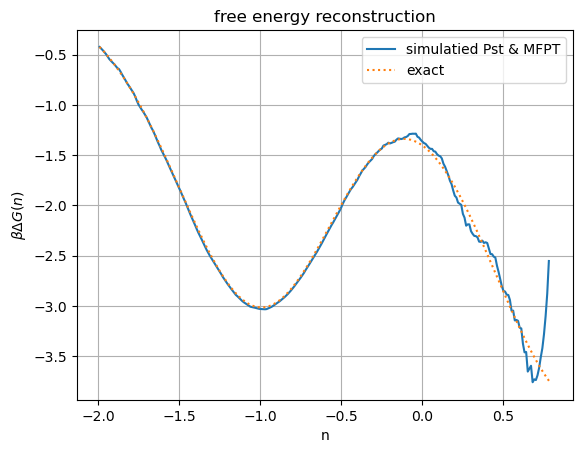

In [19]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
simu_Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, n_arr[1+i], n_arr[-1])
    simu_Bx_arr[i] = -1.0/Pst_n[1+i]*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_simu_invertBx_func = interp1d(n_arr[1:-1], 1.0/simu_Bx_arr, kind='cubic') # fill_value="extrapolate")
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, n_arr[1], n_arr[1+i])
    beta_Grec2_arr[i] = beta_U(n_arr[1])+np.log(simu_Bx_arr[i]/simu_Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(n_arr[1:-2], beta_Grec2_arr[:-1], label="simulatied Pst & MFPT")
plt.plot(n_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

### Reconstruct Free Energy Using data [mfpt (mat_Mbar[0]), Pst (ria_trans.steady_state)] calculated by Transfer Matrix

#### (1) Transfer Matrix Steady State Distribution with exact MFPT

8.408819427882198e-08


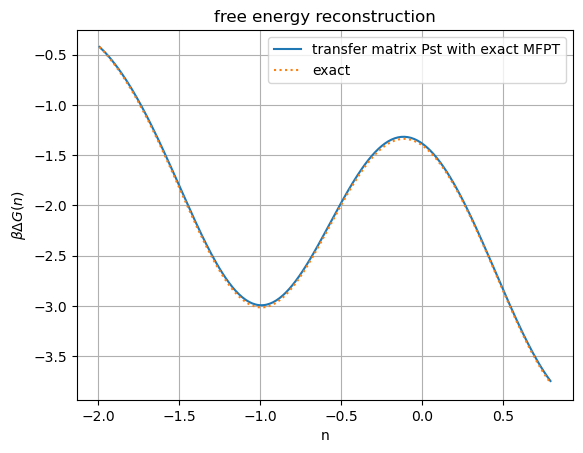

In [20]:
# interp_Pst_func = interp1d(x_arr[:-1], np.array(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], dtype=float), kind='cubic', fill_value="extrapolate")
interp_Pst_func = interp1d(x_arr[:-1], np.array(ria_trans.steady_state, dtype=float), kind='cubic', fill_value="extrapolate")
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="transfer matrix Pst with exact MFPT")
plt.plot(x_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (2) Transfer Matrix Steady State Distribution with simulated MFPT

0.0005756332315537067


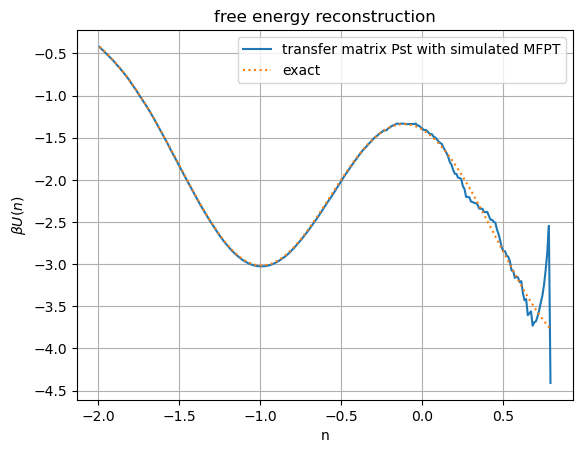

In [21]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="transfer matrix Pst with simulated MFPT")
plt.plot(x_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r'$ \beta U(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (3) Transfer Matrix Steady State Distribution with MFPT matrix (mat_Mbar)

8.984901158055555e-08


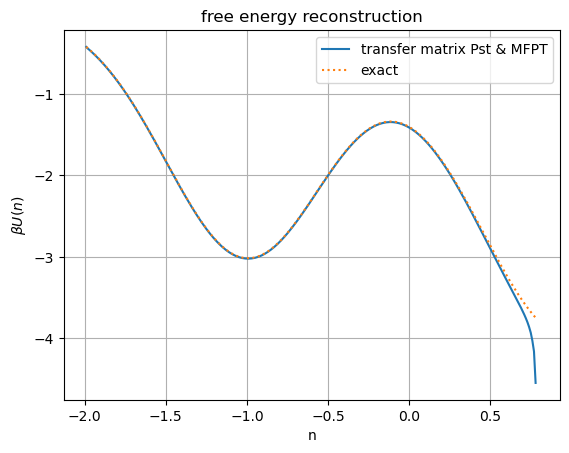

In [22]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mat_Mbar[0][-1]-mat_Mbar[0][1+i])/mat_Mbar[0][-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="transfer matrix Pst & MFPT")
plt.plot(x_arr[1:-1], beta_U(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r'$ \beta U(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

### Obtain the diffusion coefficient from B(x) and the derivate of MFPT

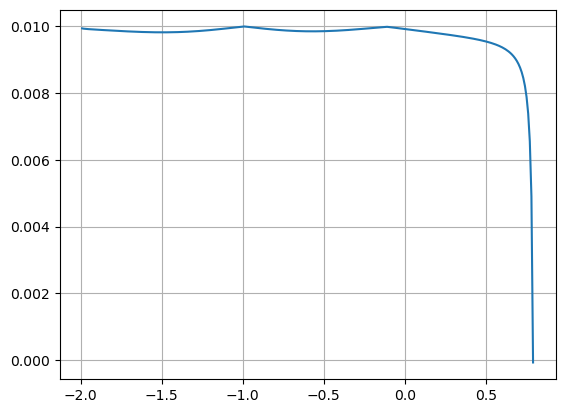

In [23]:
dt_dx_trans = np.gradient(delt_t*mat_Mbar[0], h)
D0_trans = Bx_arr/dt_dx_trans[1:]
plt.plot(x_arr[1:-1], D0_trans)
plt.grid()

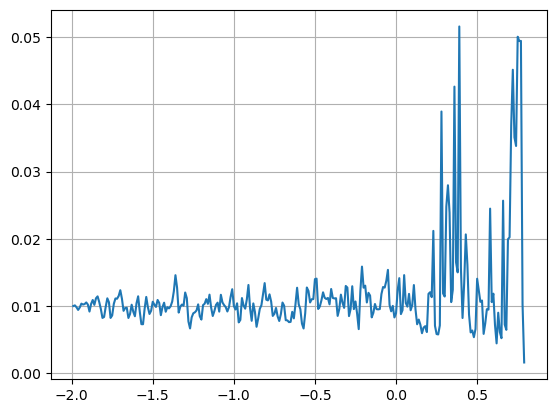

In [24]:
dt_dx_simu = np.gradient(mfpt_simu_arr, h)
D0_simu = simu_Bx_arr/dt_dx_simu[1:-1]
plt.plot(x_arr[1:-1], D0_simu)
plt.grid()